# EdgeR - Non-rarefied & abundance-filtered data 

In [1]:
library(edgeR)
library(phyloseq)
library(tidyverse)
library(metagMisc)
library(microViz)
library(conflicted)
library(pheatmap)
library(viridis)
library(gridExtra)
library(ggplot2)
library(pheatmap)

Loading required package: limma

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.0.9     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.4.1
✔ ggplot2   3.3.6     ✔ tibble    3.2.1
✔ lubridate 1.8.0     ✔ tidyr     1.2.1
✔ purrr     0.3.5     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘metagMisc’


The following object is masked from ‘package:purrr’:

    some



microViz version 0.9.6 - Copyright (C) 2022 David Barnett
* Website: https://david-barnett.github.io/microViz/
* Useful? For citation info, run: citation('microV

### Declare preferences

In [2]:
conflict_prefer("count","dplyr")
conflict_prefer("filter","dplyr")

[conflicted] Will prefer dplyr::count over any other package.
[conflicted] Will prefer dplyr::filter over any other package.


### Source functions

In [3]:
#Import miscellaneous functions for plots and edger
source("../../FlagellinDiversity/plots_functions.r")

In [57]:
nonrare.psAll.filt =readRDS("../filter_taxa_All_subsampled_median.rds")

In [58]:
nonrare.psAll.filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [59]:
tax_table_nonrare = as.data.frame(nonrare.psAll.filt@tax_table)%>%
rownames_to_column(var="Accession")

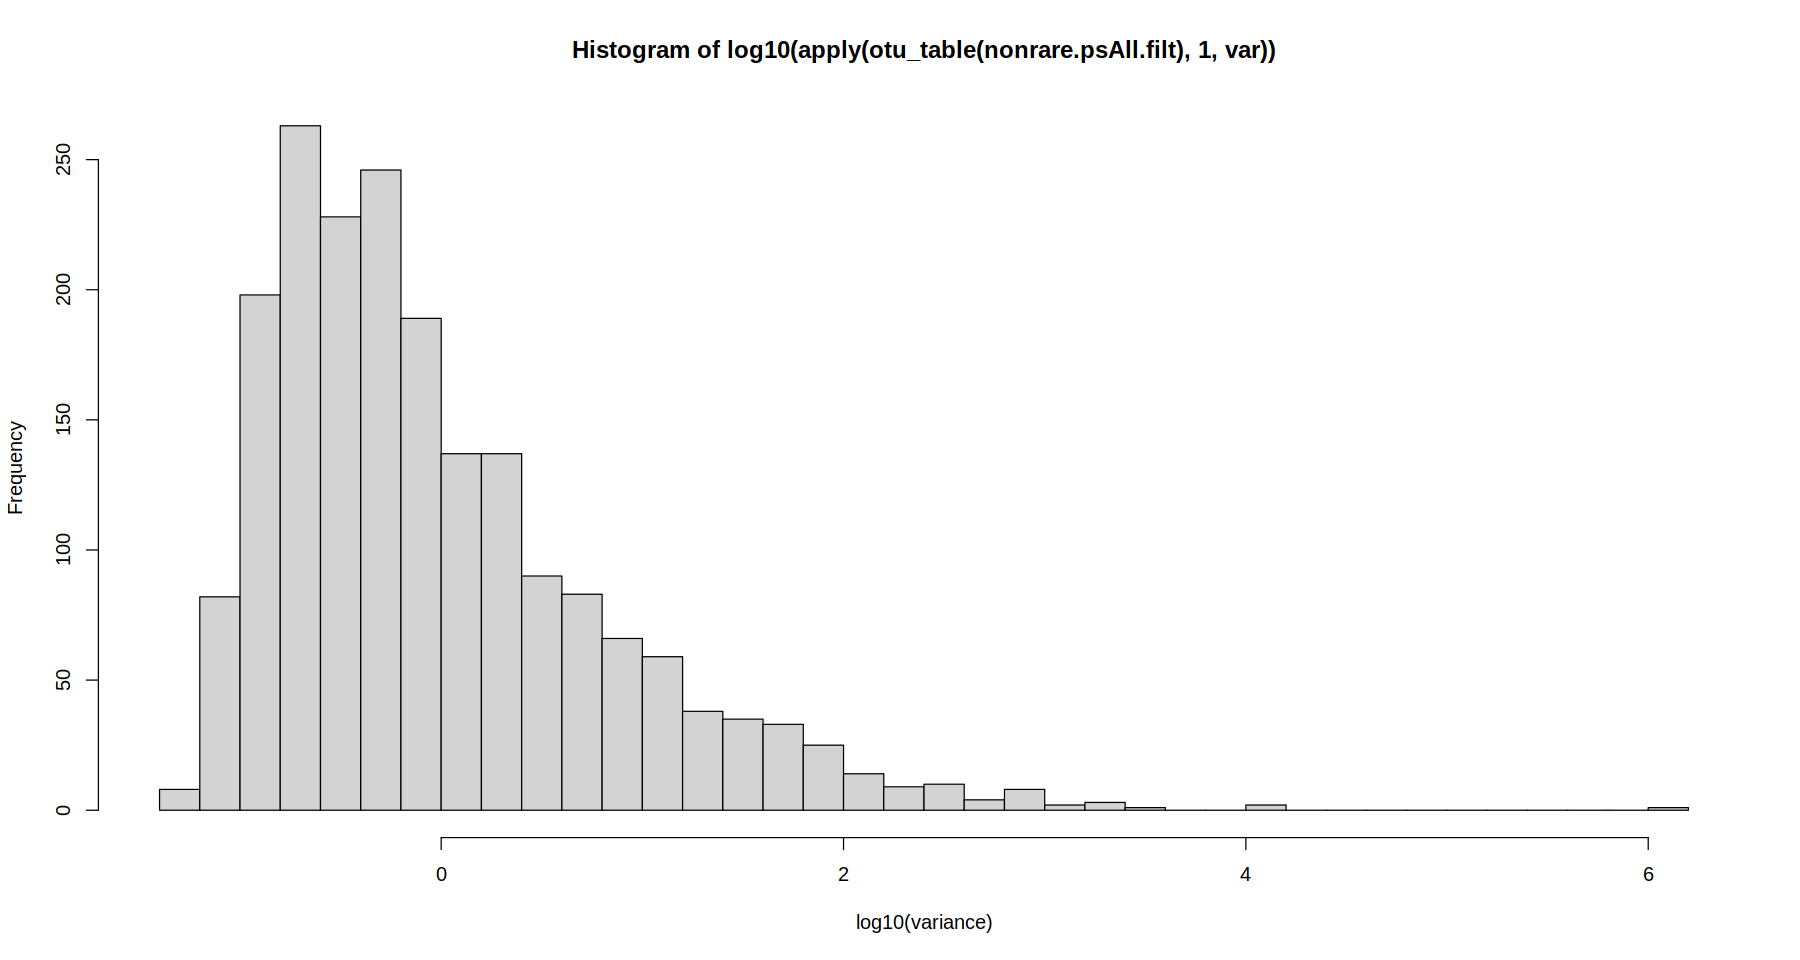

In [60]:
# #relative abundances
hist(log10(apply(otu_table(nonrare.psAll.filt), 1, var)),
     xlab="log10(variance)",breaks=50)#,
     #main="A large fraction of OTUs have very low variance")

## 1. Host vs. environmental

In [61]:
#Perform differentially abundance analysis
edger.host.env = runEdgeR(nonrare.psAll.filt,groupToCompare="biome_1")

[1] "Environmental"   "Host-associated"
[1] "BH"
[1] "exact"


In [62]:
#Table with DA flagellins
sigtab.host.env = edger.host.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host.env = edger.host.env$sigtabgen

In [63]:
nrow(sigtabgen.host.env)

[1] 623

#### Export list of Differentially Abundant flagellins

In [64]:
DA.biome1 = rownames_to_column(sigtab.host.env,var = "Accession")
#write_tsv(DA.biome1,"edgeR/DA.biome1.nonrare.filt.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


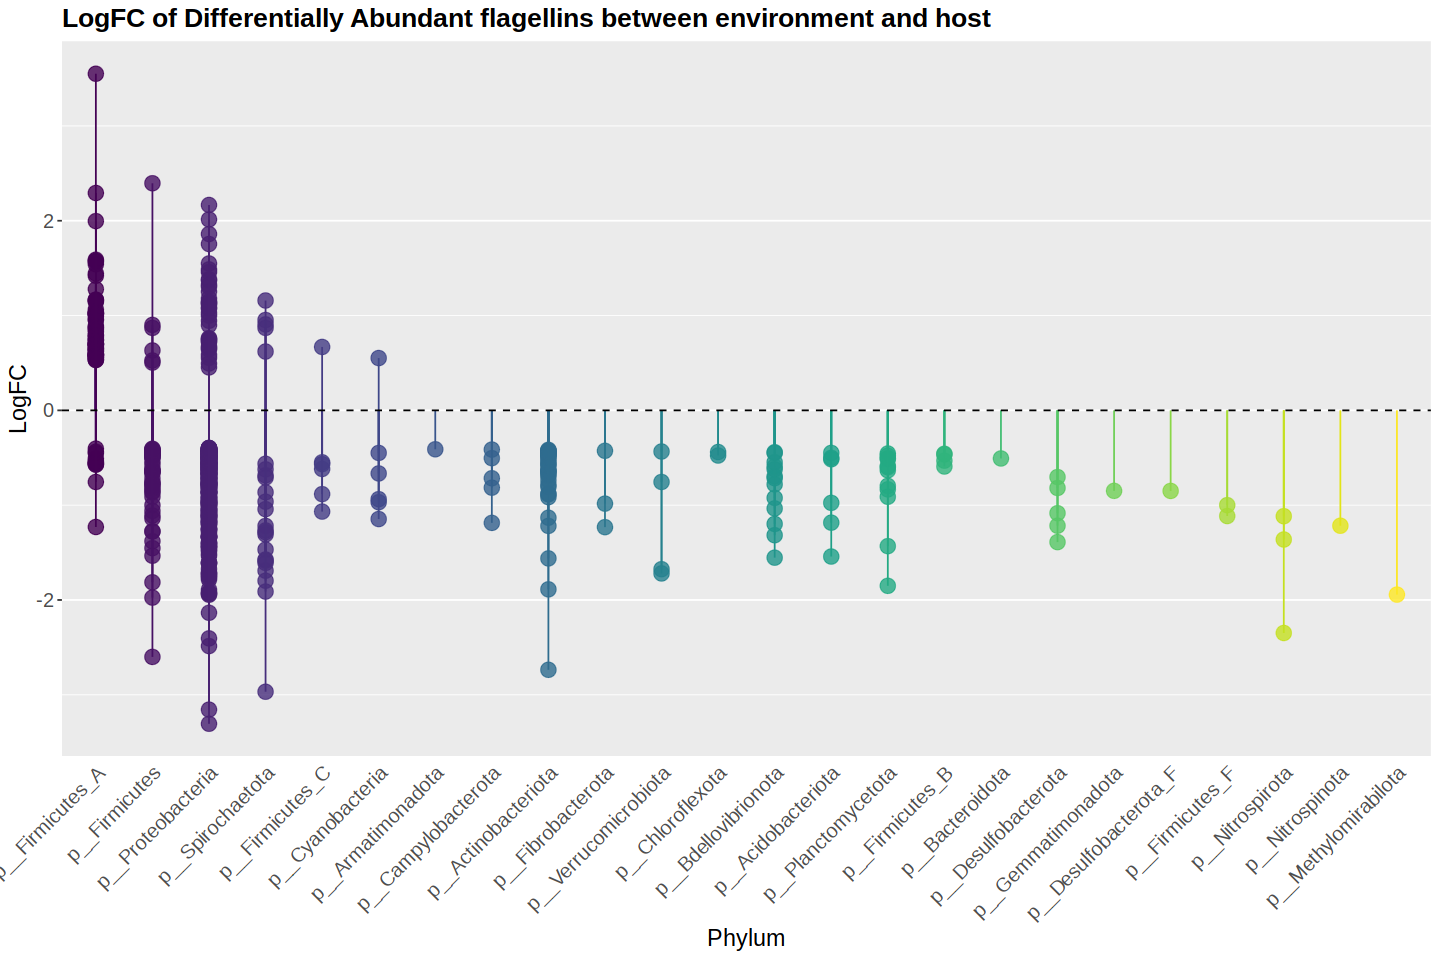

In [65]:
options(repr.plot.width=12,repr.plot.height=8)
ggplot(sigtabgen.host.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and host")+
  labs(x = "Phylum", y = "LogFC")

In [66]:
#Subset the phyloseq with the DA flagellins in biome_1
DAs.biome1=rownames(sigtab.host.env)
psDA_biome1 = prune_taxa(DAs.biome1,nonrare.psAll.filt)
psDA_biome1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 623 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 623 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 623 tips and 622 internal nodes ]

#### Create heatmap with DA flagellins

In [67]:
annotations.biome1 = annotationsForHeatmap(psDA_biome1)

In [68]:
matrix = createMatrixForHetmap(psDA_biome1)

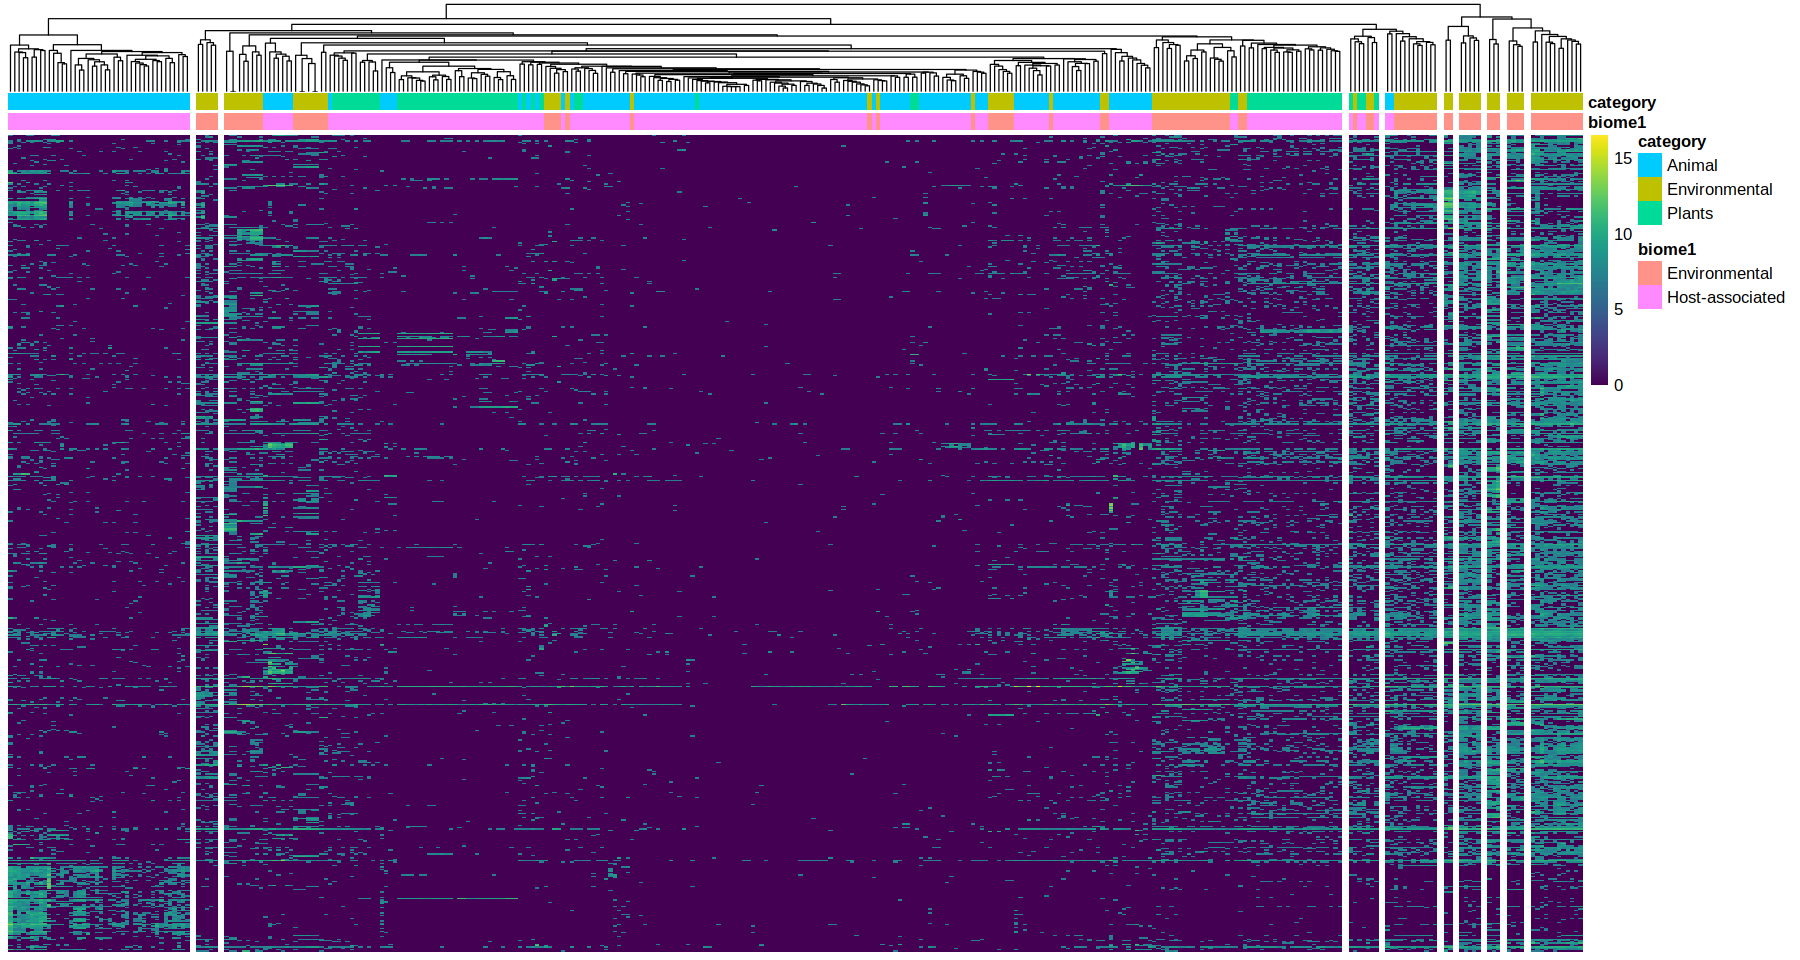

In [69]:
options(repr.plot.width=15,repr.plot.height=8)
pheatmap(matrix, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotations.biome1$annotation.row$Phylum,
         annotation_col=select(annotations.biome1$annotation.col,c(biome1,category)),
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

## 2. Animals/Environmental

In [70]:
ps.animals.env=subset_samples(nonrare.psAll.filt,category!="Plants")
ps.animals.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 277 samples ]
sample_data() Sample Data:       [ 277 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [71]:
#Perform differentially abundance analysis
edger.animal.env = runEdgeR(ps.animals.env,groupToCompare="category")

[1] "Animal"        "Environmental"
[1] "BH"
[1] "exact"


In [72]:
#Table with DA flagellins
sigtab.animal.env = edger.animal.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.animal.env = edger.animal.env$sigtabgen

In [73]:
nrow(sigtabgen.animal.env)

[1] 609

In [74]:
head(sigtab.animal.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,3.080322,11.98937,5.780637e-75,1.138786e-71
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.446868,11.46430,7.556581e-64,7.443232e-61
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.750747,11.26181,5.330136e-60,3.500123e-57
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.268495,14.43158,1.497735e-52,7.376344e-50
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.372564,11.40918,1.161668e-42,4.576974e-40
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.629497,11.07332,1.590802e-40,5.223134e-38


#### Export list of Differentially Abundant flagellins

In [75]:
DA.animals.env = rownames_to_column(sigtab.animal.env,var = "Accession")
#write_tsv(DA.animals.env,"edgeR/DA.animals.env.nonrare.filt.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


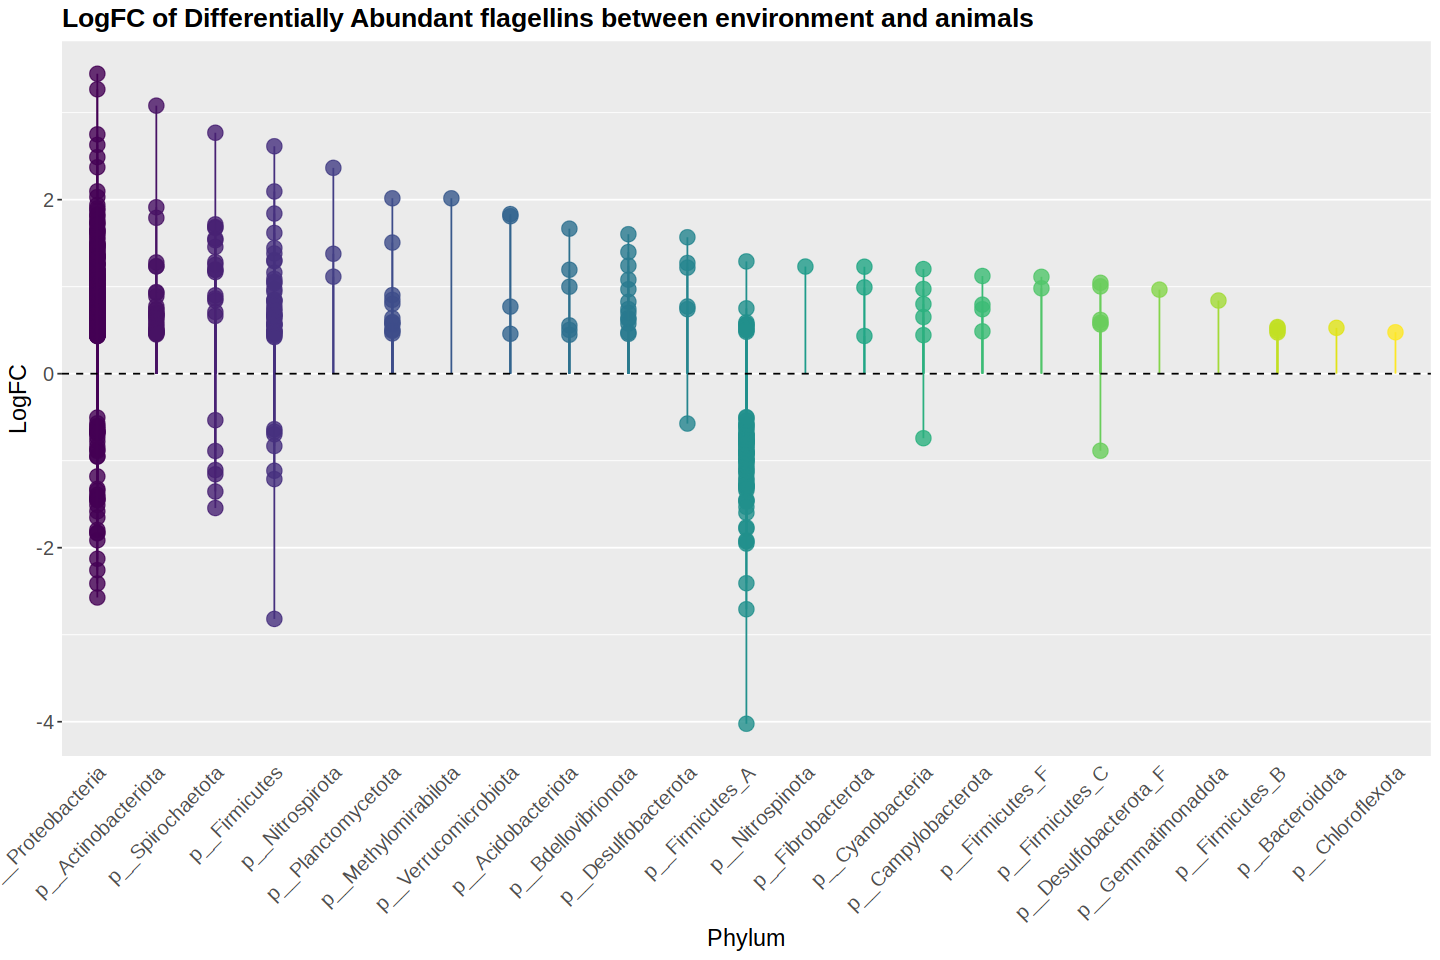

In [76]:
options(repr.plot.width=12,repr.plot.height=8)
ggplot(sigtabgen.animal.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and animals")+
  labs(x = "Phylum", y = "LogFC")

In [77]:
head(sigtabgen.animal.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,3.080322,11.98937,5.780637e-75,1.138786e-71
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.446868,11.46430,7.556581e-64,7.443232e-61
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.750747,11.26181,5.330136e-60,3.500123e-57
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.268495,14.43158,1.497735e-52,7.376344e-50
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.372564,11.40918,1.161668e-42,4.576974e-40
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.629497,11.07332,1.590802e-40,5.223134e-38


In [78]:
lachnos.env.animals =filter(sigtabgen.animal.env,Family%in%"f__Lachnospiraceae")

In [79]:
nrow(lachnos.env.animals)

[1] 68

Warning message:
“Duplicated aesthetics after name standardisation: xend”


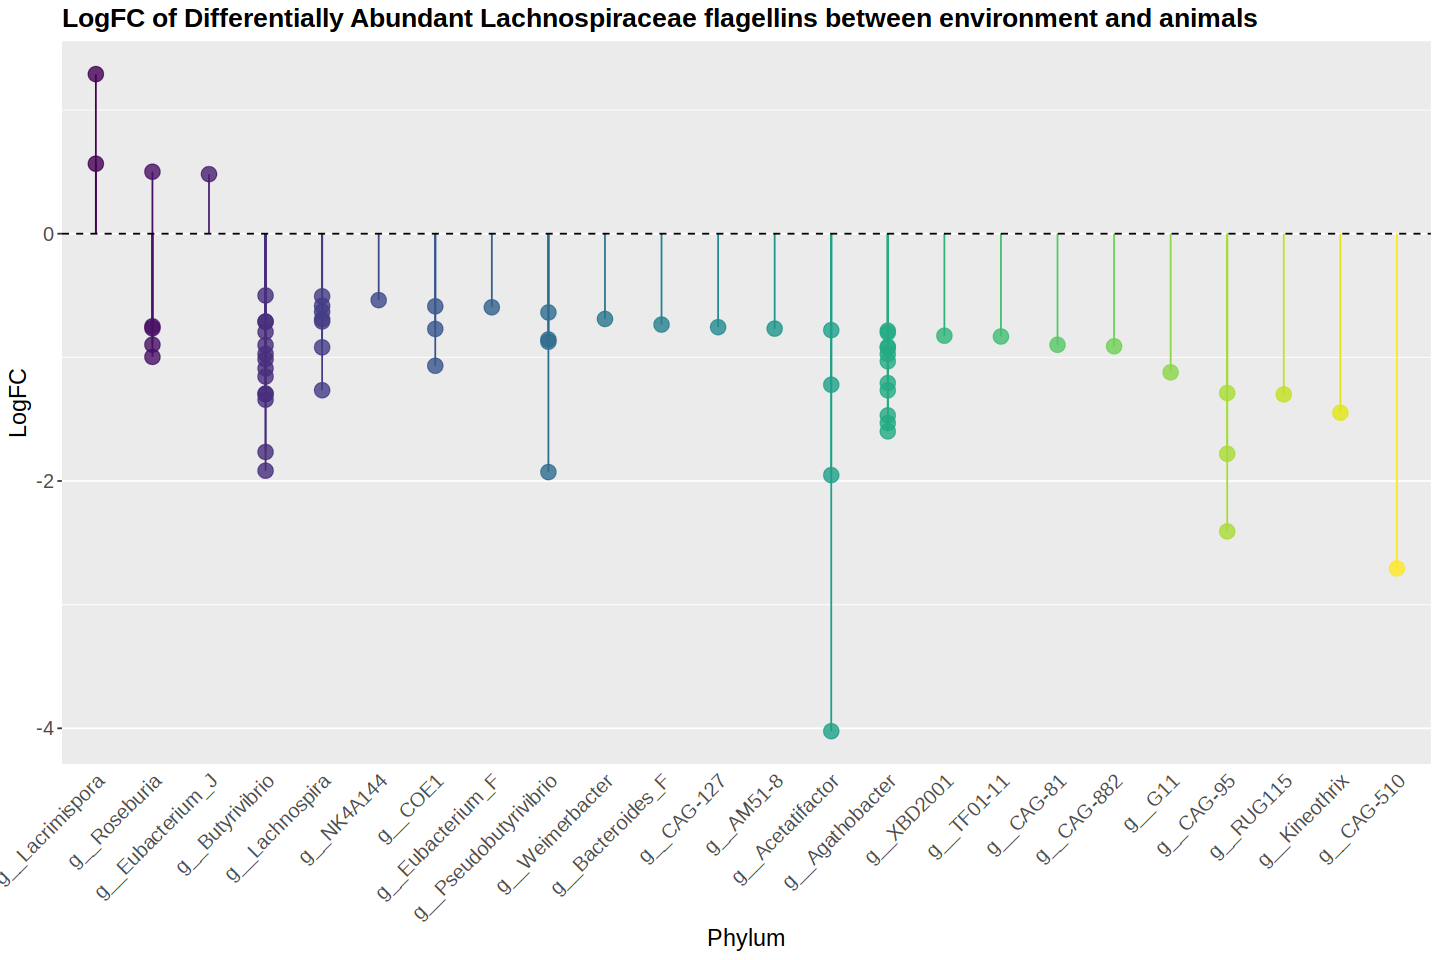

In [80]:
ggplot(lachnos.env.animals, aes(x = Genus, y = logFC, color = Genus)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant Lachnospiraceae flagellins between environment and animals")+
  labs(x = "Phylum", y = "LogFC")

## 3. Plants/Environmental

In [81]:
ps.plants.env=subset_samples(nonrare.psAll.filt,category!="Animal")
ps.plants.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [82]:
#Perform differentially abundance analysis
edger.plants.env = runEdgeR(ps.plants.env,groupToCompare="category")

[1] "Environmental" "Plants"       
[1] "BH"
[1] "exact"


In [83]:
#Table with DA flagellins
sigtab.plants.env = edger.plants.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.plants.env = edger.plants.env$sigtabgen

In [84]:
nrow(sigtabgen.plants.env)

[1] 326

In [85]:
head(sigtab.plants.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,-2.908576,14.93526,1.936465e-38,3.783853e-35
SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,2.904689,11.13411,5.201127e-31,5.081501e-28
EHS52757.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.709735,11.06175,4.533335e-26,2.952712e-23
EHS53752.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.598008,10.93431,1.415750e-25,6.915937e-23
EEO87047.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Yersinia,s__Yersinia pestis,-2.229251,11.42780,3.492954e-25,1.365046e-22
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,-3.005981,11.87206,1.206600e-21,3.495374e-19


#### Export list of Differentially Abundant flagellins

In [86]:
DA.plants.env = rownames_to_column(sigtab.plants.env,var = "Accession")
#write_tsv(DA.plants.env,"edgeR/DA.plants.env.nonrare.filt.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


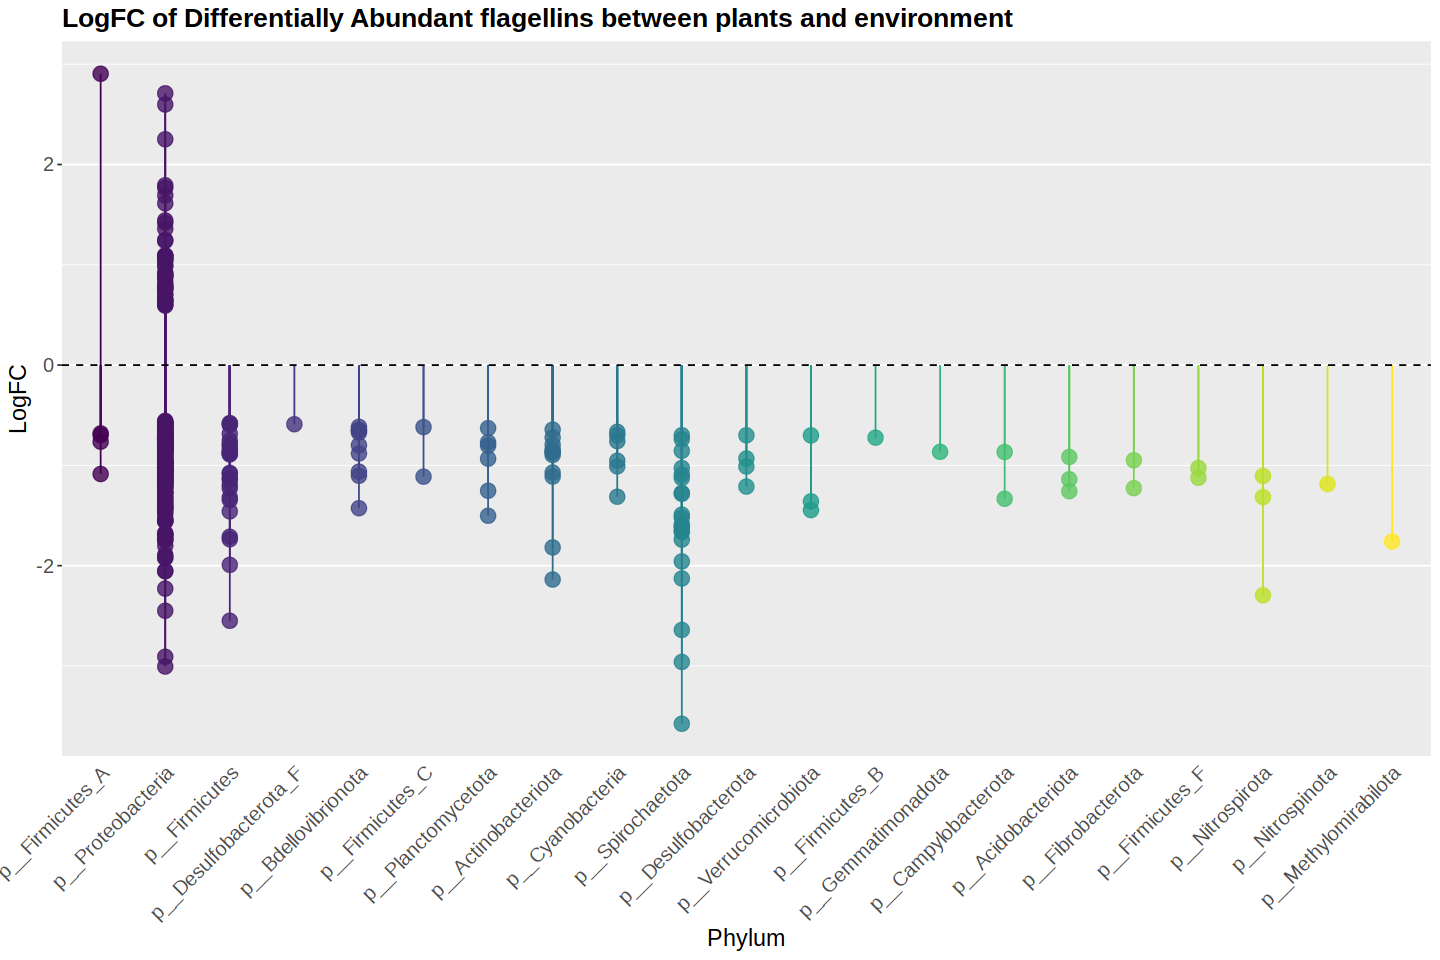

In [87]:
ggplot(sigtabgen.plants.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and environment")+
  labs(x = "Phylum", y = "LogFC")

## 4. Plants vs. animals

In [88]:
subset.host.nonrare.filt=subset_samples(nonrare.psAll.filt,biome_1=="Host-associated")

In [89]:
#Perform differentially abundance analysis
edger.host = runEdgeR(subset.host.nonrare.filt,groupToCompare="category")

[1] "Animal" "Plants"
[1] "BH"
[1] "exact"


In [90]:
#Table with DA flagellins
sigtab.host = edger.host$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host = edger.host$sigtabgen

In [91]:
nrow(sigtab.host)

[1] 203

##### Export list of Differentially Abundant flagellins

In [92]:
DA.animalsvsplants = rownames_to_column(sigtab.host,var = "Accession")
#write_tsv(DA.animalsvsplants,"edgeR/DA.animalvsplant.nonrare.filt.tsv")
head(DA.animalsvsplants)

,Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,2.884722,11.08710,1.264558e-52,2.489915e-49
2,EHS52757.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.741936,11.02470,1.162711e-45,1.144689e-42
3,EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.662170,11.01887,9.249745e-44,6.070916e-41
4,EHS53752.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.546891,10.93027,1.695101e-41,8.344137e-39
5,PYB77514.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium wuzhouense,1.825485,10.66818,5.888295e-28,2.318811e-25
6,KPF42046.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp001296045,1.667280,10.63215,7.724394e-26,2.534889e-23


#### Plots

##### A. Phlyum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


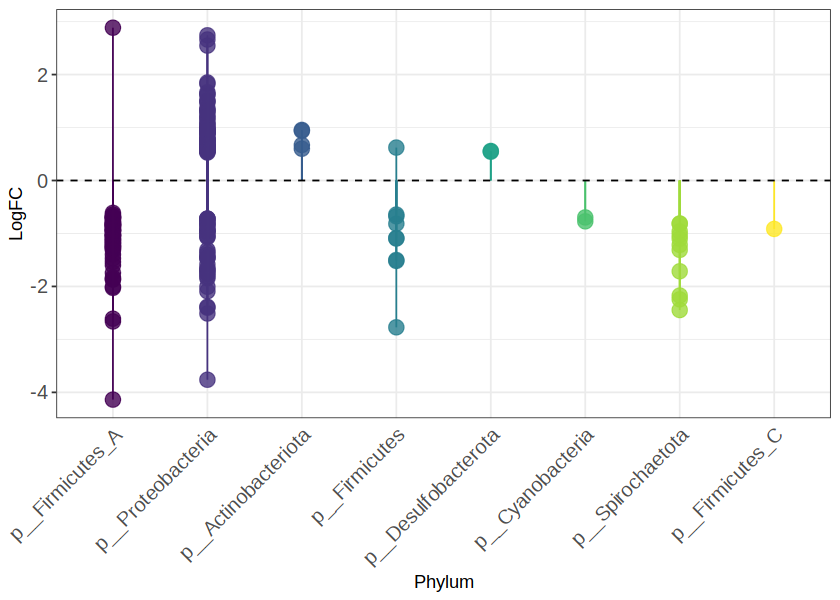

In [93]:
options(repr.plot.width=7,repr.plot.height=5)

ggplot(sigtabgen.host, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
theme_bw()+
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.position="none") +
    labs(x = "Phylum", y = "LogFC")#+
#ggtitle("LogFC of Differentially Abundant flagellins between plants and animals")

##### B. Family-level

In [94]:
options(repr.plot.width=12,repr.plot.height=6)

png(file="plants.vs.animals.enriched.png",width=12,height=6)
ggplot(sigtabgen.host, aes(x = Family, y = logFC, color = Phylum)) + geom_point(size=4,alpha=0.8) + 
theme_bw()+
  geom_segment(aes(y=0,yend=logFC,xend=Family,xend=Family),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) #+
 # ggtitle("LogFC of Differentially Abundant flagellins between plants and animals")
dev.off()

Warning message:
“Duplicated aesthetics after name standardisation: xend”


png 
  2

##### C. Genus-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


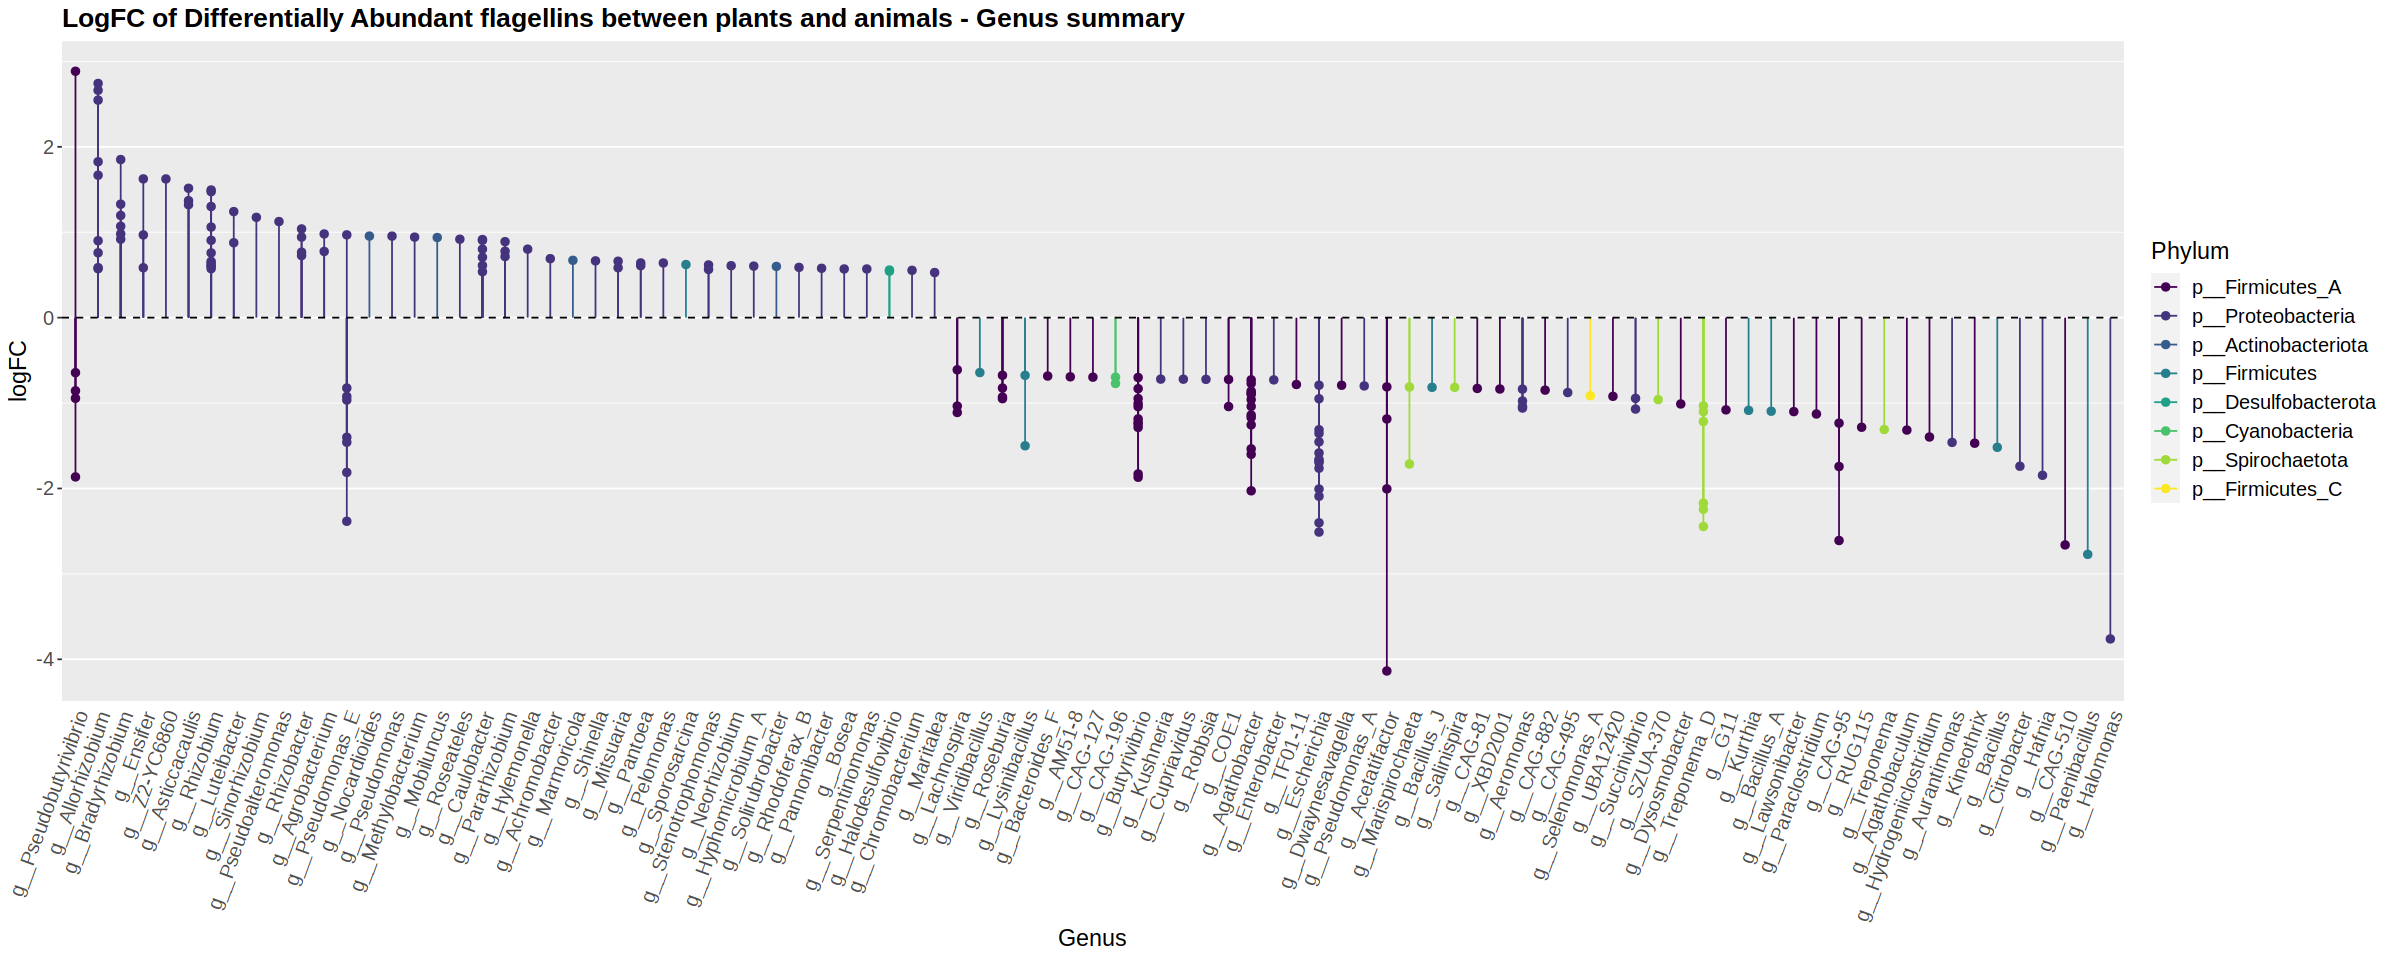

In [95]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host, aes(x = Genus, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals - Genus summary")

##### D. species-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


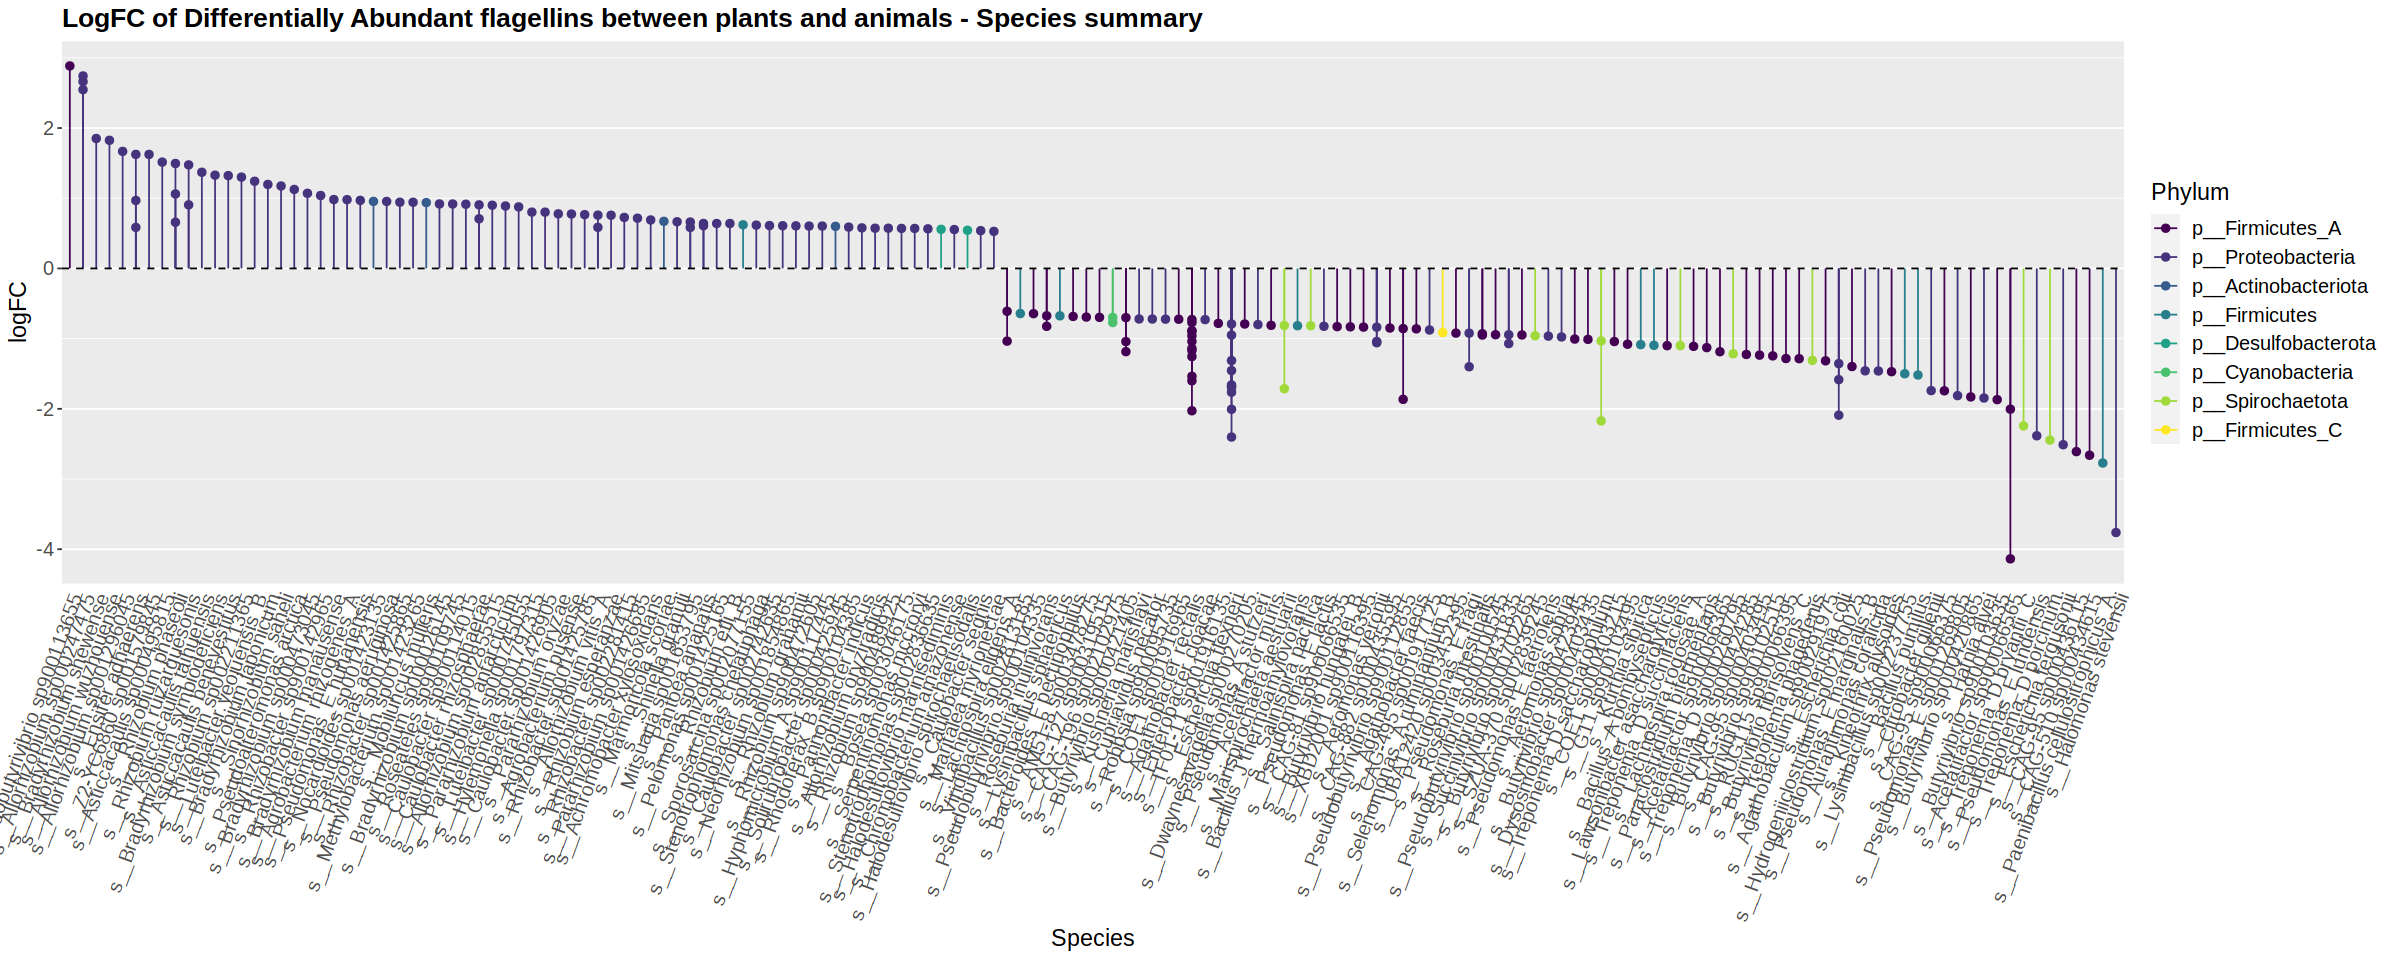

In [96]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host, aes(x = Species, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Species,xend=Species),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals - Species summary")

##### E. Plot hetamaps with DA flagellins

In [97]:
#Subset the phyloseq with the DA flagellins in biome_1
DAs.host=rownames(sigtab.host)
psDA_host = prune_taxa(DAs.host,nonrare.psAll.filt)
psDA_host

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 203 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 203 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 203 tips and 202 internal nodes ]

In [98]:
annotations.host = annotationsForHeatmap(psDA_host)

In [99]:
matrix.host = createMatrixForHetmap(psDA_host)

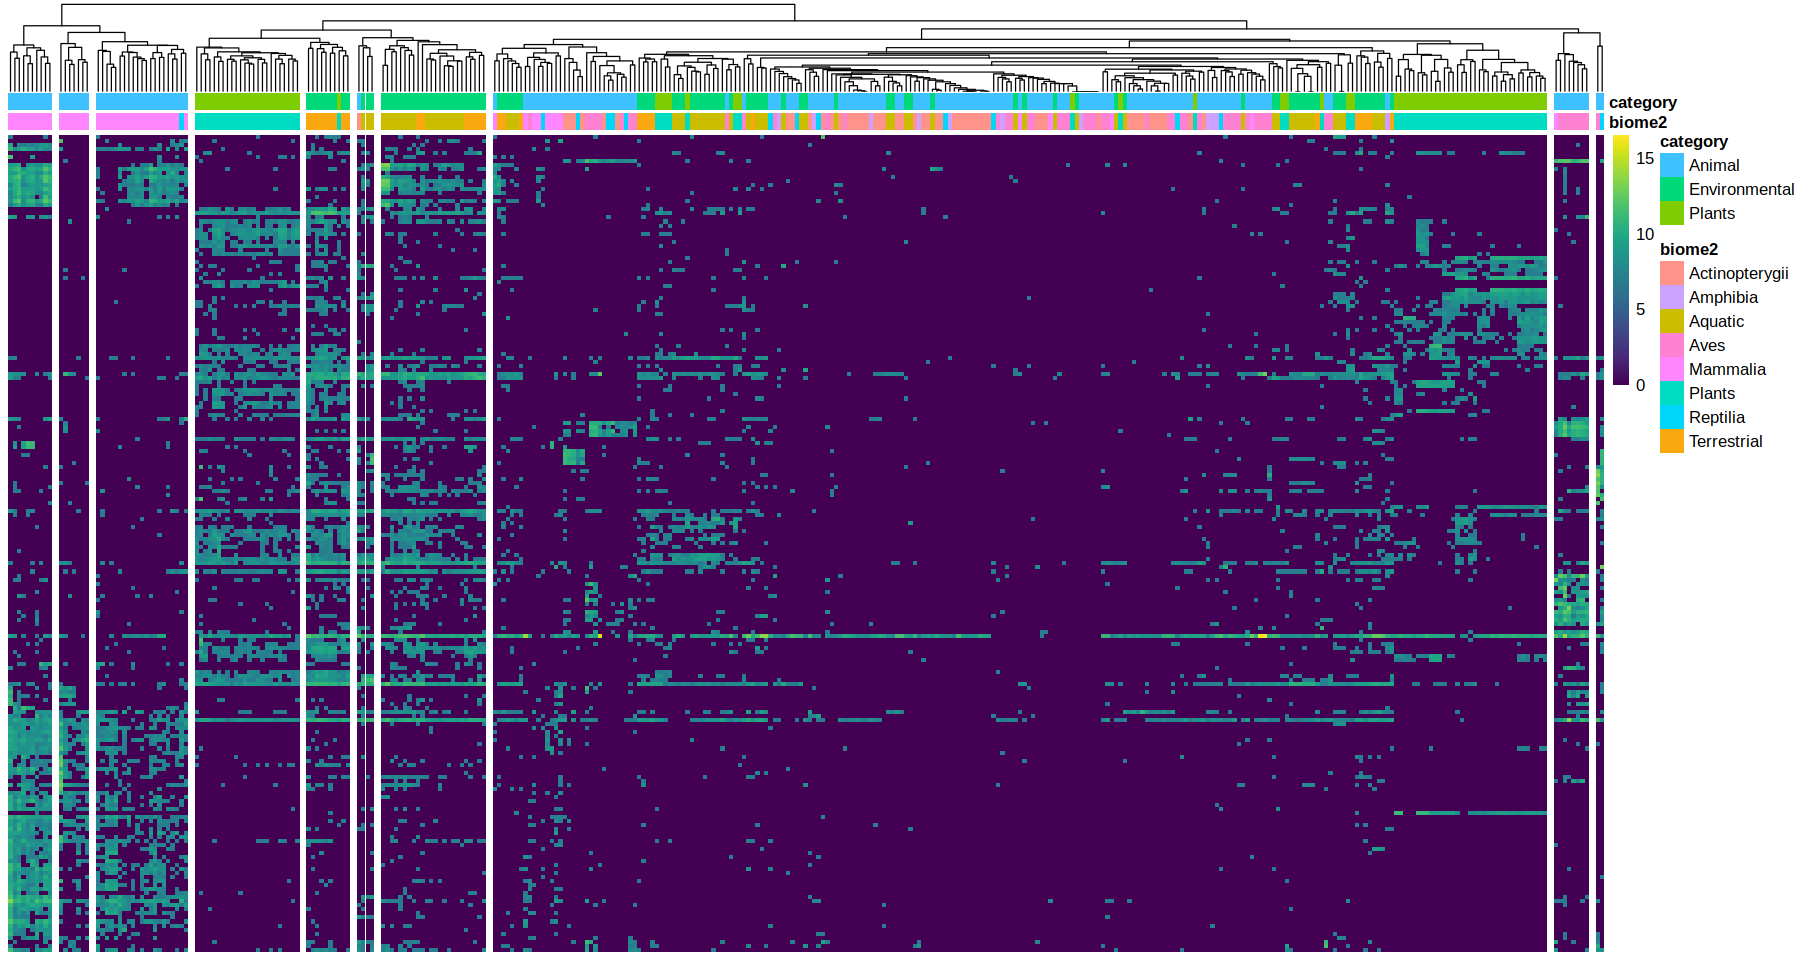

In [100]:
options(repr.plot.width=15,repr.plot.height=8)
pheatmap(matrix.host, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotations.biome1$annotation.row$Phylum,
         annotation_col=select(annotations.biome1$annotation.col,c(biome2,category)),
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

## 5. Mammals vs. non-mammals

In [101]:
ps.verts=subset_samples(nonrare.psAll.filt,category=="Animal")
ps.verts

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [102]:
#Perform differentially abundance analysis
edger.verts = runEdgeR(ps.verts,groupToCompare="mammals")

[1] "Mammalia" "Others"  
[1] "BH"
[1] "exact"


In [103]:
#Table with DA flagellins
sigtab.verts = edger.verts$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.verts = edger.verts$sigtabgen

In [104]:
nrow(sigtabgen.verts)
nrow(sigtab.verts)

[1] 198

[1] 198

In [105]:
head(sigtab.verts)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
RHP37040.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Acetatifactor,s__Acetatifactor sp900066565,-5.406454,13.26222,1.504151e-72,2.796217e-69
SJZ39514.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D porcinum,-3.959653,11.79228,1.437939e-61,1.336564e-58
CDA67770.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__CAG-510,s__CAG-510 sp000434615,-4.287332,11.94802,5.126482e-59,3.176710e-56
WP_022931566.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D bryantii_C,-3.702149,11.62705,4.534968e-57,2.107626e-54
CDD46301.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__CAG-95,s__CAG-95 sp000436115,-4.117898,11.90718,4.177139e-55,1.553060e-52
EIC00583.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D saccharophilum,-3.482338,11.59900,1.287153e-50,3.988028e-48


#### Export list of Differentially Abundant flagellins

In [106]:
DA.mammals = rownames_to_column(sigtab.verts,var = "Accession")
#write_tsv(DA.mammals,"edgeR/DA.mammals.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


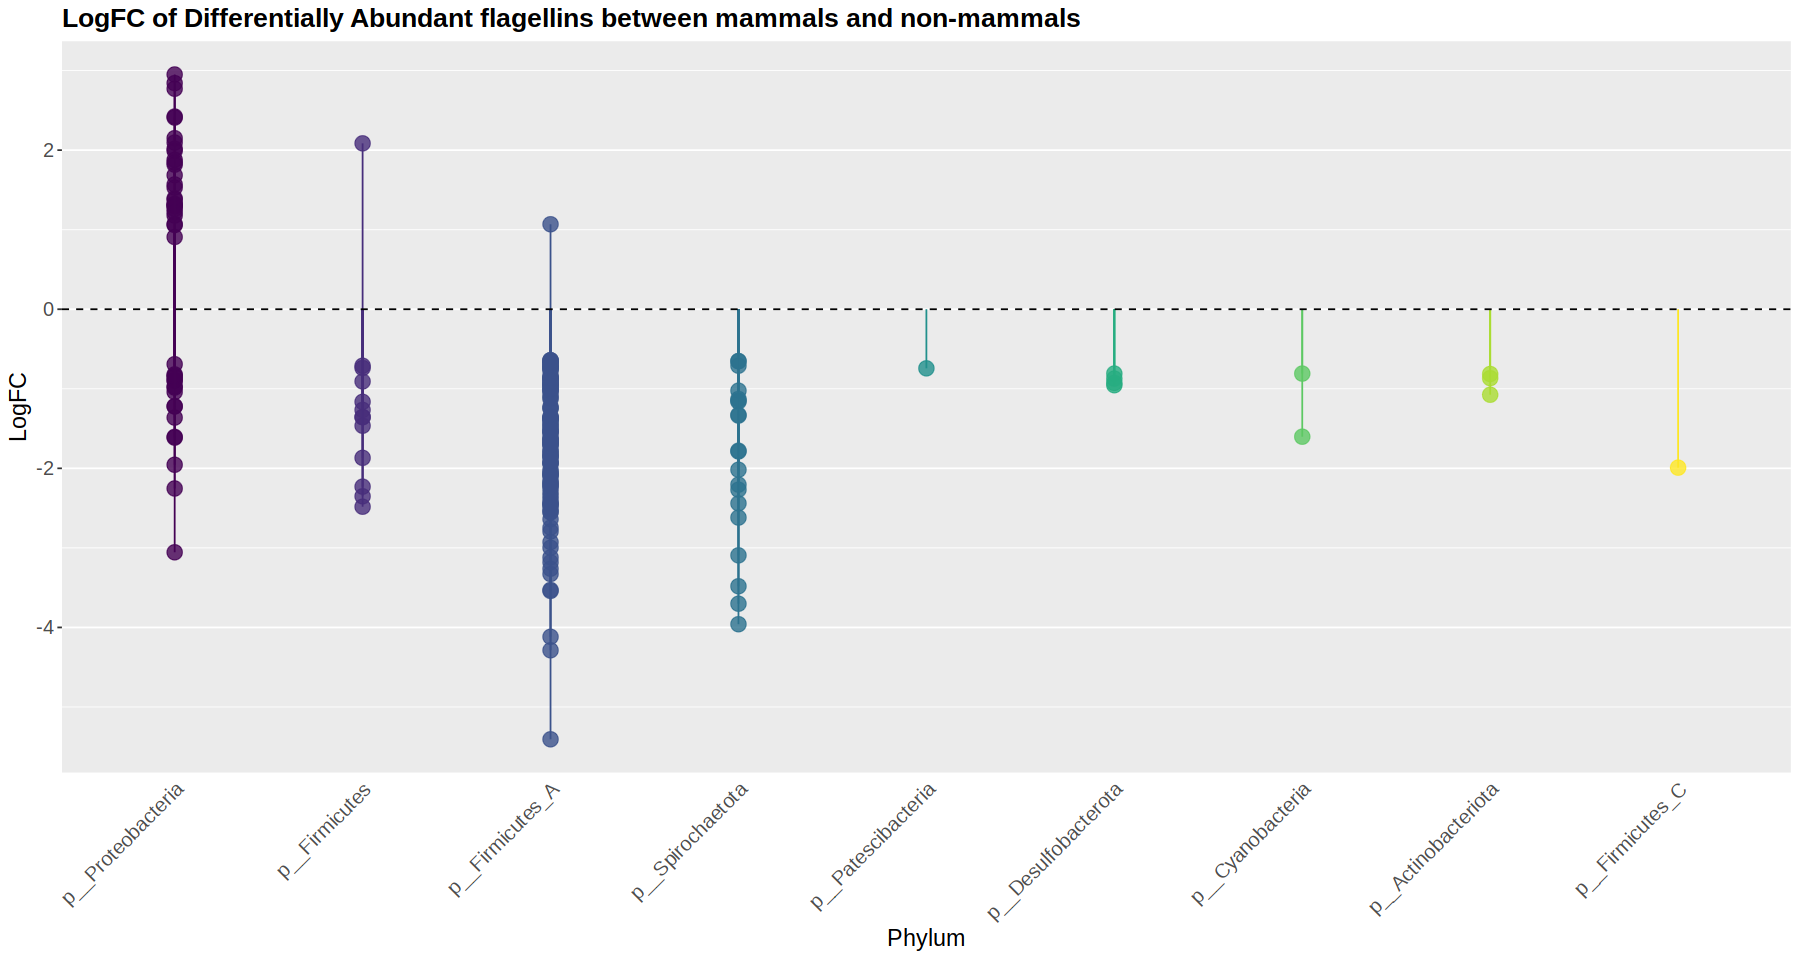

In [107]:
ggplot(sigtabgen.verts, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between mammals and non-mammals")+
  labs(x = "Phylum", y = "LogFC")